# DNMT3A benchmarking with JAPANESE BIOBANK CH DATA

#### Data from: Saiki et al 2021, Nat Med, Combined landscape of single-nucleotide variants and copy number alterations in clonal hematopoiesis https://www.nature.com/articles/s41591-021-01411-9

#### DNMT3A methylation activity from Lue NZ, Garcia EM, Ngan KC, Lee C, Doench JG, Liau BB. Base editor scanning charts the DNMT3A activity landscape. Nat Chem Biol 2023;19:176–86.

### 1. Get and arrange data
### 2. Create positive set
### 3. Create negative set
### 4. Evaluation BoostDM vs Experimental assay

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import copy
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 30)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from matplotlib import rcParams

In [58]:
# Data from Lue. et al Nat Chem Biol 2023
# Upload file generated in DNMT3A_training_cohort.ipynb
DNMT3A_score = pd.read_csv('../../../Paper_data/Experimental_data/DNMT3A/DNMT3A_evaluating_mutations.csv', sep='\t')
DNMT3A_score

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,boostDM_score,boostDM_pred
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched,0.995337,1
1,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched,0.744854,1
2,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched,0.986471,1
3,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched,0.979201,1
4,DNMT3A2_428,CATCAAAGAGAGACAGCACC,Missense,MTase,D641N,1.455682,enriched,0.790142,1
...,...,...,...,...,...,...,...,...,...
151,DNMT3A2_417,GGGACAGGTGGGTAAACCTT,Missense,Inter2,V626I,-0.257446,unchanged,0.006466,0
152,DNMT3A2_552,GGCATCAATCATCACAGGGT,Missense,MTase,D781N,-0.298170,unchanged,0.162090,0
153,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged,0.001803,0
154,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged,0.362861,0


## 1. Get and arrange data

In [3]:
### Open Saiki et al. Mutations
japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')
japan_mutations = japan_ch[japan_ch['Start'].notna()]
japan_mutations = japan_mutations[japan_mutations['Gene.refGene']=='DNMT3A']
print(len(japan_mutations))
japan_mutations.columns

1706


/tmp/jobs/jramis/9874679/ipykernel_9197/4266612524.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,52,53,56,57,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')


Index(['id', 'sex', 'age', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Func.refGene',
       'Gene.refGene', 'GeneDetail.refGene', 'ExonicFunc.refGene',
       'Merge_Func', 'AAChange.refGene', 'cytoBand', 'genomicSuperDups',
       'esp6500siv2_all', 'X1000g2010nov_all', 'X1000g2014oct_all',
       'X1000g2014oct_afr', 'X1000g2014oct_eas', 'X1000g2014oct_eur', 'snp131',
       'snp138', 'snp131NonFlagged', 'snp138NonFlagged', 'cosmic68wgs',
       'cosmic70', 'clinvar_20150629', 'SIFT_score', 'SIFT_pred',
       'Polyphen2_HDIV_score', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'LRT_score', 'LRT_pred', 'MutationTaster_score',
       'MutationTaster_pred', 'MutationAssessor_score',
       'MutationAssessor_pred', 'FATHMM_score', 'FATHMM_pred',
       'RadialSVM_score', 'RadialSVM_pred', 'LR_score', 'LR_pred',
       'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP.._RS',
       'phyloP46way_placental', 'phyloP100way_vertebrate',
       'SiPhy_29way_logOdds', '

In [4]:
### Select only SNVs

japan_mutations_sel = japan_mutations[japan_mutations['Ref'].isin(['A','C','T','G']) &
                              japan_mutations['Alt'].isin(['A','C','T','G'])].reset_index(drop=True)
print(japan_mutations_sel['ExonicFunc.refGene'].value_counts())
print(len(japan_mutations_sel))

nonsynonymous SNV    903
stopgain             184
Name: ExonicFunc.refGene, dtype: int64
1218


In [5]:
### Arrange data
# Change chromosome nomenclature
japan_mutations_sel['Chr'] = japan_mutations_sel['Chr'].astype(int)

In [6]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chr']), x['Start'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])

# Apply to 12 genes selection
japan_mutations_sel['pos_hg38'] = japan_mutations_sel.apply(lambda x: hg38_conv(x), axis=1)

In [7]:
### Substitute U2AF1;U2AF1L5  by U2AF1

japan_mutations_sel['Gene.refGene'] = japan_mutations_sel['Gene.refGene'].apply(lambda x: x.split(';')[0])
japan_mutations_sel['Gene.refGene'].value_counts()

DNMT3A    1218
Name: Gene.refGene, dtype: int64

In [8]:
### Select unique mutations
japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chr,Gene.refGene,pos_hg38,Ref,Alt
0,2,DNMT3A,25243910.0,C,T
1,2,DNMT3A,25234414.0,A,C
2,2,DNMT3A,25243936.0,G,T
3,2,DNMT3A,25240422.0,G,T
4,2,DNMT3A,25246259.0,C,A
...,...,...,...,...,...
570,2,DNMT3A,25234322.0,C,G
571,2,DNMT3A,25246657.0,G,T
572,2,DNMT3A,25240420.0,T,G
573,2,DNMT3A,25240397.0,G,A


In [10]:
#eliminate mutations in introns
japan_mutations_sel = japan_mutations_sel[-japan_mutations_sel['AAChange.refGene'].isna()]
print(len(japan_mutations_sel))

1087


In [11]:
# Include aa change
result =[]
for x in japan_mutations_sel['AAChange.refGene']:
    results = [a.split('.')[-1] for a in x.split(',') if 'DNMT3A:NM_022552' in a] or [np.nan]
    result.append(results[0])
japan_mutations_sel['aachange'] = result

In [12]:
# Remove those without aa change
japan_mutations_sel = japan_mutations_sel[~japan_mutations_sel['aachange'].isna()]
print(len(japan_mutations_sel))

1085


In [13]:
japan_mutations_sel['aachange'] = japan_mutations_sel['aachange'].str.replace('X', '*')

In [14]:
japan_mutations_sel['aachange'].value_counts()

R882H    64
R882C    50
Y735C    24
R635W    22
R771*    19
         ..
C549W     1
L819V     1
A628S     1
S775F     1
P743S     1
Name: aachange, Length: 486, dtype: int64

In [15]:
japan_mutations_sel = japan_mutations_sel[japan_mutations_sel['aachange'].isin(DNMT3A_score['Mutation_list'])]
japan_mutations_sel['aachange'].value_counts()

P700L    19
W313*    14
Q886*     5
Q816*     5
G706R     4
W698*     3
C497Y     2
H694Y     1
S312F     1
S669F     1
A910V     1
E907K     1
R366C     1
Q615*     1
E756K     1
S337L     1
L798F     1
W581*     1
G726D     1
R720H     1
G796D     1
W330*     1
Name: aachange, dtype: int64

## 2. Create positive set

In [16]:
### Get positive set of unique
japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt', 'aachange']].drop_duplicates().reset_index(drop=True)
japan_mutations_unq

,Chr,Gene.refGene,pos_hg38,Ref,Alt,aachange
0,2,DNMT3A,25234362.0,G,A,Q886*
1,2,DNMT3A,25234299.0,C,T,E907K
2,2,DNMT3A,25240720.0,C,T,W698*
3,2,DNMT3A,25240697.0,C,T,G706R
4,2,DNMT3A,25240447.0,C,T,G726D
5,2,DNMT3A,25244163.0,G,A,Q615*
6,2,DNMT3A,25247077.0,G,A,R366C
7,2,DNMT3A,25240719.0,C,T,W698*
8,2,DNMT3A,25241564.0,G,A,H694Y
9,2,DNMT3A,25247670.0,G,A,S312F


In [21]:
### Change names
japan_mutations_unq = japan_mutations_unq.rename(columns={'Gene.refGene':'gene', 'Chr':'chr', 'pos_hg38':'pos',
                                   'Ref':'ref', 'Alt':'alt'})
japan_mutations_unq = japan_mutations_unq[['gene','chr','pos','ref','alt','aachange']]
### Create variable of set
japan_mutations_unq['Set'] = 1
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,DNMT3A,2,25234362.0,G,A,Q886*,1
1,DNMT3A,2,25234299.0,C,T,E907K,1
2,DNMT3A,2,25240720.0,C,T,W698*,1
3,DNMT3A,2,25240697.0,C,T,G706R,1
4,DNMT3A,2,25240447.0,C,T,G726D,1
5,DNMT3A,2,25244163.0,G,A,Q615*,1
6,DNMT3A,2,25247077.0,G,A,R366C,1
7,DNMT3A,2,25240719.0,C,T,W698*,1
8,DNMT3A,2,25241564.0,G,A,H694Y,1
9,DNMT3A,2,25247670.0,G,A,S312F,1


In [22]:
#gene frequency
japan_mutations_unq['gene'].value_counts()

DNMT3A    24
Name: gene, dtype: int64

In [23]:
#gene frequency
japan_mutations_unq['gene'].value_counts(normalize=True)*100

DNMT3A    100.0
Name: gene, dtype: float64

In [24]:
### Create dictionary
gene_frec_pos = dict(japan_mutations_unq['gene'].value_counts())
gene_frec_pos

{'DNMT3A': 24}

# 3. Create negative set

### 3.1. MSKCC

In [25]:
# Open observed mutaitons from MSKCC
MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",
                          sep='\t')
print(len(MSKCC_IMPACT))
MSKCC_IMPACT.columns

246585


/tmp/jobs/jramis/9874679/ipykernel_9197/484754725.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [26]:
### MSK negative
MSKCC_negative = MSKCC_IMPACT[MSKCC_IMPACT['response'] == 0].reset_index(drop=True)
print(len(MSKCC_negative))

241750


### 3.2. TCGA

In [27]:
# Open TCGA observed mutations
TCGA = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_TCGA_FULL.regression_data.tsv",
                          sep='\t')
print(len(TCGA))
TCGA.columns

23205


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [28]:
### MSK negative
TCGA_negative = TCGA[TCGA['response'] == 0].reset_index(drop=True)
len(TCGA_negative)

22750

### 3.2. HMF

In [29]:
# Open TCGA observed mutations
HMF = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WGS_HMF_FULL.regression_data.tsv",
                          sep='\t')
print(len(HMF))
HMF.columns

10047


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [30]:
### MSK negative
HMF_negative = HMF[HMF['response'] == 0].reset_index(drop=True)
len(HMF_negative)

9850

### 3.4. General negative set

In [31]:
### Concatenate 3 db

negative_set = pd.concat([MSKCC_negative, TCGA_negative, HMF_negative]).reset_index(drop=True)
len(negative_set)

274350

In [32]:
### Select 12 genes

# Select 12 genes
negative_set = negative_set[negative_set['gene'].isin(['DNMT3A'])].reset_index(drop=True)
len(negative_set)

132500

In [33]:
len(set(DNMT3A_score['Mutation_list']))

127

In [34]:
negative_set = negative_set[negative_set['aachange'].isin(DNMT3A_score['Mutation_list'].tolist())]
negative_set

,alt,chr,gene,pos,ref,response,PhyloP,aachange,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,CLUSTL_SCORE,motif,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,CLUSTL_cat_1,CLUSTL_cat_2,HotMaps_cat_1,HotMaps_cat_2,smRegions_cat_1,smRegions_cat_2
62,A,2,DNMT3A,25234367,G,0,10.000000,A884V,0,0.0,0.0,0.0,0.0,0.0,3630.5363,NaN,1,0,0,0,1,0,0,0,0,0
178,A,2,DNMT3A,25244220,G,0,1.455078,R596W,0,0.0,0.0,0.0,0.0,0.0,0.0000,NaN,1,0,0,0,0,0,0,0,0,0
191,T,2,DNMT3A,25248117,C,0,7.132812,A259T,0,0.0,0.0,0.0,0.0,0.0,0.0000,NaN,1,0,0,0,0,0,0,0,0,0
193,T,2,DNMT3A,25240378,C,0,7.906250,R749H,0,0.0,0.0,0.0,0.0,0.0,0.0000,ENST00000264709:PF00145:634:767;,1,0,0,0,0,0,0,0,1,0
244,T,2,DNMT3A,25247679,C,0,1.593750,R309H,0,0.0,0.0,0.0,0.0,0.0,0.0000,ENST00000264709:PF00855:291:374;,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132243,T,2,DNMT3A,25240658,C,0,5.023438,A719T,0,0.0,0.0,0.0,0.0,0.0,766.3811,ENST00000264709:PF00145:634:767;,1,0,0,0,1,0,0,0,1,0
132273,T,2,DNMT3A,25245279,C,0,0.244995,V510I,0,0.0,0.0,0.0,0.0,0.0,0.0000,NaN,1,0,0,0,0,0,0,0,0,0
132406,T,2,DNMT3A,25240654,C,0,7.859375,R720H,0,0.0,0.0,0.0,0.0,0.0,766.3811,ENST00000264709:PF00145:634:767;,1,0,0,0,1,0,0,0,1,0
132453,T,2,DNMT3A,25240709,C,0,7.859375,D702N,0,0.0,0.0,0.0,0.0,0.0,0.0000,ENST00000264709:PF00145:634:767;,1,0,0,0,0,0,1,0,1,0


In [35]:
len(set(negative_set['aachange']))

127

In [36]:
### Type of mutations

negative_set[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      3904
csqn_type_nonsense       332
csqn_type_splicing         0
csqn_type_synonymous       0
dtype: int64

In [37]:
# Genes
negative_set['gene'].value_counts()

DNMT3A    4236
Name: gene, dtype: int64

In [39]:
### Select unique

negative_set_unq = negative_set[['gene','chr','pos','ref','alt','aachange']].drop_duplicates().reset_index(drop=True)
### Create variable of set
negative_set_unq['Set'] = 0
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,DNMT3A,2,25234367,G,A,A884V,0
1,DNMT3A,2,25244220,G,A,R596W,0
2,DNMT3A,2,25248117,C,T,A259T,0
3,DNMT3A,2,25240378,C,T,R749H,0
4,DNMT3A,2,25247679,C,T,R309H,0
...,...,...,...,...,...,...,...
250,DNMT3A,2,25235794,G,A,S837L,0
251,DNMT3A,2,25244577,G,A,R544C,0
252,DNMT3A,2,25239176,C,T,A788T,0
253,DNMT3A,2,25241669,G,A,R659C,0


### Chack if negative set has repetitions

In [40]:
japan_mutations_unq['pos'] = japan_mutations_unq['pos'].astype('int')
japan_mutations_unq['chr'] = japan_mutations_unq['chr'].astype('int')

japan_mutations_unq = japan_mutations_unq.drop_duplicates()
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,DNMT3A,2,25234362,G,A,Q886*,1
1,DNMT3A,2,25234299,C,T,E907K,1
2,DNMT3A,2,25240720,C,T,W698*,1
3,DNMT3A,2,25240697,C,T,G706R,1
4,DNMT3A,2,25240447,C,T,G726D,1
5,DNMT3A,2,25244163,G,A,Q615*,1
6,DNMT3A,2,25247077,G,A,R366C,1
7,DNMT3A,2,25240719,C,T,W698*,1
8,DNMT3A,2,25241564,G,A,H694Y,1
9,DNMT3A,2,25247670,G,A,S312F,1


In [41]:
negative_set_unq['pos'] = negative_set_unq['pos'].astype('int')
negative_set_unq['chr'] = negative_set_unq['chr'].astype('int')

negative_set_unq = negative_set_unq.drop_duplicates()
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,DNMT3A,2,25234367,G,A,A884V,0
1,DNMT3A,2,25244220,G,A,R596W,0
2,DNMT3A,2,25248117,C,T,A259T,0
3,DNMT3A,2,25240378,C,T,R749H,0
4,DNMT3A,2,25247679,C,T,R309H,0
...,...,...,...,...,...,...,...
133,DNMT3A,2,25244163,G,A,Q615*,0
134,DNMT3A,2,25248047,G,A,P282L,0
135,DNMT3A,2,25244313,G,A,L565F,0
136,DNMT3A,2,25245309,G,A,L500F,0


# 4. Evaluation BoostDM vs Experimental assay

In [43]:
### Get file with BoostDM + Harvard predicitons

boostDM_harvard = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_run20230803.tsv.gz', sep='\t')
boostDM_harvard

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO
0,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,C,K2Q,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,0,2,0.0,0.0,0.0,0.0
1,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,G,K2E,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,1,2,0.0,0.0,0.0,0.0
2,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,T,K2*,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.989503,1,-0.151095,0.0,0.0,0.000000,-0.304486,-0.415152,0.0,0.0,0.0,0.0,0.0,0.371912,2.419656,-0.038151,0.070408,2,2,0.0,0.0,0.0,0.0
3,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,C,K2T,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,3,2,0.0,0.0,0.0,0.0
4,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,G,K2R,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,4,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,C,A2G,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2146,2,0.0,0.0,0.0,0.0
87935,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,T,A2E,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2147,2,0.0,0.0,0.0,0.0
87936,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,A,A2S,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2148,2,0.0,0.0,0.0,0.0
87937,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,G,A2P,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2149,2,0.0,0.0,0.0,0.0


In [44]:
### Import rule-based deffinition of CH

import sys
sys.path.append("../../../Paper_data/Expert_curated_rules/")
from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import WHO_CH

### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['Set']==1) & (data[method]==1)])
    tn = len(data[(data['Set']==0) & (data[method]==0)])
    fp = len(data[(data['Set']==0) & (data[method]==1)])
    fn = len(data[(data['Set']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [45]:
eval_boostdm = []
eval_experimental = []


for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    # Get negative set with gene frequency equal to positive set
    negative_set = negative_set_unq.sample(gene_frec_pos['DNMT3A'], random_state=seed).reset_index(drop=True)
    # Get negative set with gene frequency equal to positive set
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq, negative_set]).reset_index(drop=True)

    ## Merge with BoostDM & Harvard predictions
    validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
    
    DNMT3A_positive = DNMT3A_score[DNMT3A_score['Hit_status'] == 'enriched']['Mutation_list'].tolist()
    validation_set_predictions['experimental'] = validation_set_predictions['aachange_x'].apply(lambda x: 1 if x in DNMT3A_positive else 0)

    ## Calculate all statistics for each method
    for method in ['boostDM_class', 'experimental']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:    
            # Calculate statistic
            statistics.append(quality_statistic(validation_set_predictions, method=method, statistic=statistic))
        if method == 'boostDM_class': eval_boostdm.append(statistics)
        elif method == 'experimental': eval_experimental.append(statistics)


In [47]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'experimental': pd.DataFrame(eval_experimental).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q1': pd.DataFrame(eval_experimental).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q3': pd.DataFrame(eval_experimental).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.732130,0.660865,0.684524,0.756579,0.625000,0.693269
1,F1,0.802464,0.628456,0.766667,0.821429,0.608696,0.647463
2,Accuracy,0.761667,0.652917,0.708333,0.791667,0.625000,0.682292
3,Precision,0.691992,0.685393,0.638889,0.718750,0.636364,0.727632
4,Recall,0.958333,0.583333,0.958333,0.958333,0.583333,0.583333
5,NPV,0.929134,0.631842,0.916667,0.937500,0.615385,0.652094


In [48]:
plot_data = results_dataframe_12.iloc[:,0:3]
plot_data

,Statistic,BoostDM,experimental
0,$F_{50}$,0.732130,0.660865
1,F1,0.802464,0.628456
2,Accuracy,0.761667,0.652917
3,Precision,0.691992,0.685393
4,Recall,0.958333,0.583333
5,NPV,0.929134,0.631842


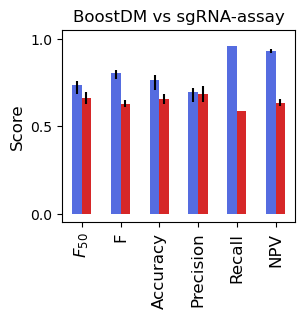

In [49]:
plot_data = results_dataframe_12.iloc[:,0:3]

mpl.style.use('default')
plot_data.plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in results_dataframe_12.iloc[::-1].iterrows():
    ci = [[abs(row.BoostDM-row.BoostDM_Q1)], [abs(row.BoostDM_Q3-row.BoostDM)]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in results_dataframe_12.iloc[::-1].iterrows():
    ci = [[row.experimental-row.experimental_Q1], [row.experimental_Q3-row.experimental]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.title('BoostDM vs sgRNA-assay', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(6), [r"$F_{50}$", 'F', 'Accuracy', 'Precision', 'Recall', 'NPV'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

In [50]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)

error_data

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.732130,0.660865,0.684524,0.756579,0.625000,0.693269
1,Precision,0.691992,0.685393,0.638889,0.718750,0.636364,0.727632
2,Recall,0.958333,0.583333,0.958333,0.958333,0.583333,0.583333


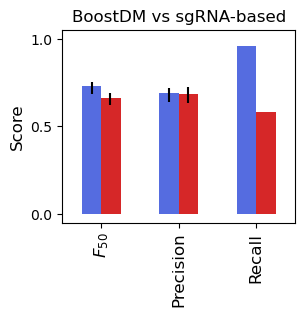

In [51]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[abs(row.BoostDM-row.BoostDM_Q1)], [abs(row.BoostDM_Q3-row.BoostDM)]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.experimental-row.experimental_Q1], [row.experimental_Q3-row.experimental]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.title('BoostDM vs sgRNA-based', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
plt.show()

In [52]:
# SAVE
error_data.to_csv('Japanese_crossvalidation_DNMT3A.csv',
                         sep='\t', index=False)

In [53]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}


# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['Set'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

In [54]:
for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    # Get negative set with gene frequency equal to positive set
    negative_set = negative_set_unq.sample(gene_frec_pos['DNMT3A'], random_state=seed).reset_index(drop=True)
    # Get negative set with gene frequency equal to positive set
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq, negative_set]).reset_index(drop=True)

    if i == 0:
        validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
    else:
        validation_set_predic = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
        
        validation_set_predictions = pd.concat([validation_set_predictions, validation_set_predic]).reset_index(drop=True)
        
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,aachange_y,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO
0,DNMT3A,2,25234362,G,A,Q886*,1,ENST00000264709,ENSG00000119772,Q886*,3630.5363,1,1,0,10.000000,1,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.987590,1,0.789530,0.0,0.574664,-0.003023,0.286382,0.028281,0.0,0.000186,0.003217,0.0,0.002140,-0.154600,0.249817,-0.055764,0.184218,240,886,1.0,1.0,1.0,1.0
1,DNMT3A,2,25234299,C,T,E907K,1,ENST00000264709,ENSG00000119772,E907K,3630.5363,1,0,0,7.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.774027,1,0.559895,0.0,-0.518379,-0.131539,0.895745,0.000581,0.0,0.000208,0.002872,0.0,0.002299,-0.282383,-0.068630,-0.086297,0.163033,53,907,1.0,0.0,1.0,1.0
2,DNMT3A,2,25240720,C,T,W698*,1,ENST00000264709,ENSG00000119772,W698*,0.0000,0,0,1,7.859375,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.995337,1,-0.023292,0.0,-0.088477,0.205672,0.890339,0.000044,0.0,0.000219,0.001929,0.0,0.002476,0.966869,0.277897,-0.096718,0.197093,1931,698,1.0,1.0,1.0,1.0
3,DNMT3A,2,25240697,C,T,G706R,1,ENST00000264709,ENSG00000119772,G706R,0.0000,0,0,1,7.859375,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.842473,1,-0.050101,0.0,-0.318512,0.398324,0.990764,-0.000065,0.0,0.000215,0.001913,0.0,0.002432,-0.297718,-0.055048,-0.092329,0.151248,1862,706,1.0,0.0,1.0,1.0
4,DNMT3A,2,25240447,C,T,G726D,1,ENST00000264709,ENSG00000119772,G726D,766.3811,1,0,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.668241,1,0.178299,0.0,-0.477361,0.327579,0.524411,0.000020,0.0,0.000211,0.001933,0.0,0.002457,-0.271399,-0.052465,-0.085347,0.158215,1679,726,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,DNMT3A,2,25246715,G,A,T395I,0,ENST00000264709,ENSG00000119772,T395I,0.0000,0,0,0,7.464844,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.018122,0,-0.103067,0.0,-0.486560,-0.194639,-0.443839,-0.000097,0.0,0.000216,0.002347,0.0,0.002217,-0.460258,-0.089076,-0.102736,0.141782,4656,395,0.0,0.0,0.0,0.0
2396,DNMT3A,2,25240409,G,A,H739Y,0,ENST00000264709,ENSG00000119772,H739Y,766.3811,1,0,1,3.419922,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.889666,1,0.659934,0.0,-0.311904,0.919441,-0.226802,-0.000116,0.0,0.000215,0.001184,0.0,0.001949,-0.178673,-0.086403,-0.039186,0.170000,1563,739,1.0,0.0,1.0,1.0
2397,DNMT3A,2,25236968,G,A,Q816*,0,ENST00000264709,ENSG00000119772,Q816*,0.0000,0,0,0,9.648438,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.965060,1,-0.086007,0.0,-0.160881,-0.085138,0.088618,0.000065,0.0,0.000205,0.002985,0.0,0.002363,1.057935,0.520291,-0.092391,0.196913,870,816,1.0,1.0,1.0,1.0
2398,DNMT3A,2,25247077,G,A,R366C,0,ENST00000264709,ENSG00000119772,R366C,0.0000,0,0,1,5.761719,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.125352,0,-0.127913,0.0,-0.387571,0.694170,-0.665535,-0.000121,0.0,0.000215,0.001346,0.0,0.002121,-0.308647,-0.151432,-0.050168,0.150986,4920,366,1.0,0.0,0.0,0.0


In [55]:
validation_set_predictions.Set.value_counts()

1    1200
0    1200
Name: Set, dtype: int64

In [56]:
experimental_met = []
for x in validation_set_predictions['aachange_x']:
    experimental_met.append(DNMT3A_score[DNMT3A_score['Mutation_list'] == x]['sgRNA_score_d9_citrine_positive'].iloc[0])
validation_set_predictions['experimental_met'] = experimental_met
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,aachange_y,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO,experimental_met
0,DNMT3A,2,25234362,G,A,Q886*,1,ENST00000264709,ENSG00000119772,Q886*,3630.5363,1,1,0,10.000000,1,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.987590,1,0.789530,0.0,0.574664,-0.003023,0.286382,0.028281,0.0,0.000186,0.003217,0.0,0.002140,-0.154600,0.249817,-0.055764,0.184218,240,886,1.0,1.0,1.0,1.0,0.788555
1,DNMT3A,2,25234299,C,T,E907K,1,ENST00000264709,ENSG00000119772,E907K,3630.5363,1,0,0,7.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.774027,1,0.559895,0.0,-0.518379,-0.131539,0.895745,0.000581,0.0,0.000208,0.002872,0.0,0.002299,-0.282383,-0.068630,-0.086297,0.163033,53,907,1.0,0.0,1.0,1.0,0.507914
2,DNMT3A,2,25240720,C,T,W698*,1,ENST00000264709,ENSG00000119772,W698*,0.0000,0,0,1,7.859375,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.995337,1,-0.023292,0.0,-0.088477,0.205672,0.890339,0.000044,0.0,0.000219,0.001929,0.0,0.002476,0.966869,0.277897,-0.096718,0.197093,1931,698,1.0,1.0,1.0,1.0,1.751051
3,DNMT3A,2,25240697,C,T,G706R,1,ENST00000264709,ENSG00000119772,G706R,0.0000,0,0,1,7.859375,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.842473,1,-0.050101,0.0,-0.318512,0.398324,0.990764,-0.000065,0.0,0.000215,0.001913,0.0,0.002432,-0.297718,-0.055048,-0.092329,0.151248,1862,706,1.0,0.0,1.0,1.0,0.140088
4,DNMT3A,2,25240447,C,T,G726D,1,ENST00000264709,ENSG00000119772,G726D,766.3811,1,0,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.668241,1,0.178299,0.0,-0.477361,0.327579,0.524411,0.000020,0.0,0.000211,0.001933,0.0,0.002457,-0.271399,-0.052465,-0.085347,0.158215,1679,726,1.0,0.0,1.0,1.0,0.249986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,DNMT3A,2,25246715,G,A,T395I,0,ENST00000264709,ENSG00000119772,T395I,0.0000,0,0,0,7.464844,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.018122,0,-0.103067,0.0,-0.486560,-0.194639,-0.443839,-0.000097,0.0,0.000216,0.002347,0.0,0.002217,-0.460258,-0.089076,-0.102736,0.141782,4656,395,0.0,0.0,0.0,0.0,0.439321
2396,DNMT3A,2,25240409,G,A,H739Y,0,ENST00000264709,ENSG00000119772,H739Y,766.3811,1,0,1,3.419922,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.889666,1,0.659934,0.0,-0.311904,0.919441,-0.226802,-0.000116,0.0,0.000215,0.001184,0.0,0.001949,-0.178673,-0.086403,-0.039186,0.170000,1563,739,1.0,0.0,1.0,1.0,0.280420
2397,DNMT3A,2,25236968,G,A,Q816*,0,ENST00000264709,ENSG00000119772,Q816*,0.0000,0,0,0,9.648438,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.965060,1,-0.086007,0.0,-0.160881,-0.085138,0.088618,0.000065,0.0,0.000205,0.002985,0.0,0.002363,1.057935,0.520291,-0.092391,0.196913,870,816,1.0,1.0,1.0,1.0,0.874551
2398,DNMT3A,2,25247077,G,A,R366C,0,ENST00000264709,ENSG00000119772,R366C,0.0000,0,0,1,5.761719,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.125352,0,-0.127913,0.0,-0.387571,0.694170,-0.665535,-0.000121,0.0,0.000215,0.001346,0.0,0.002121,-0.308647,-0.151432,-0.050168,0.150986,4920,366,1.0,0.0,0.0,0.0,0.596686


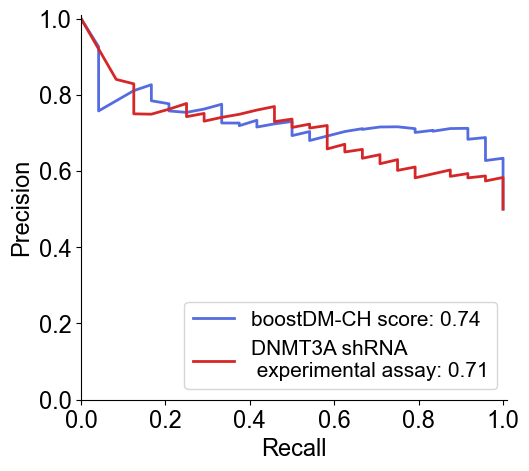

In [57]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(validation_set_predictions, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(validation_set_predictions, 'experimental_met', ax=ax, color='#d62728', lw=2, alpha=1)
# gene_crossval_harv_equal['prob_DNMT3A_met'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'DNMT3A shRNA\n experimental assay: {auc_score:.2}'], fontsize=15, loc='lower right')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()